In [ ]:
"""
전이학습을 통한 Classification 문제 해결
전이학습은 기존에 훈련 된 모델의 가중치를 가져와서 모델에
적용시키는 학습 방법
"""

In [106]:
# 모델 사용에 필요한 라이브러리 import
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [107]:
# 전이학습에 대한 기본적인 개념
# 가중치 초기화를 무작위로 한 후 가중치를 순전파, 역전파를 통해 update를 하지만
# 이 전이학습의 경우는, 기존에 미리 학습되어있는 신경망을 통해 초기화를 한다.
# 초기화 된 가중치는 마지막에 연결되어있는 전연결 부분을 제외하고,
# 마지막 전연결 부분은 무작위의 가중치를 갖는 새로운 계층으로 대체되어 이 계층만
# 학습되게 한다.

In [108]:
#Data augumentattion, normaliztion(데이토 증가, 일반화) : 과적합 방지 위해 사용
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        }

#데이터를 불러오는 경로를 설정

data_dir='./hymenoptera_data'
#tip : os는 os에서 사용하는 명령어를 그대로 불러올 수 있음
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x])
                 for x in ['train', 'val']}

#데이터로더를 불러오는 설정

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                             shuffle = True, num_workers=0)
                for x in ['train', 'val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#CUDA(GPU 가속화) 사용이 가능하게 만드는 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

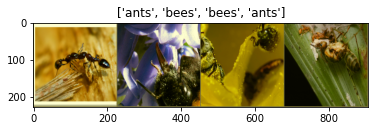

In [109]:
#사용하게 될 데이터 시각화하기
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.225])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
#학습 데이터의 배치를 얻는 과정
inputs, classes = next(iter(dataloaders['train']))

#배치로부터 격자 형태의 grid를 만드는 과정
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [91]:
#모델 학습하기

def train_model(model, criterion, optimizer, scheduler, num_epochs = 100):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0   #0.0으로 하면 자동으로 float / 0으로 하면 자동으로 int로 저장됨
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        for phase in ['train', 'val']: # phase에 따라 실행방법이 변경되게 되는데, phase가 train이라면, train을
            if phase == 'train':       # train이 아닐경우 ('val'을 의미) val으로 실행
                model.train()
            else:
                model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()
                    
                    #순전파 과정
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        #학습 단계인 경우는 역전파 + 최적화 과정을 거치게 됨
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print('{} Loss: {:.4f} ACC: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())   #state_dict : 전이함수

                print()

            time_elapsed = time.time() - since
            print('Training comoplete in {:.0f}s'.format(
                  time_elapsed // 60, time_elapsed % 60))
            print('Best val Acc: {:4f}'.format(best_acc))
            
            model.load_state_dict(best_model_wts)
            return model

In [110]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [111]:
#이미지에 대한 예측값을 보여주는 함수
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [112]:
#신경망 미세조정(fine-tune)
model_ft = models.resnet18(pretrained=True)   #resnet18의 가중치를 가져오는 구조
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)  #출력 샘플의 크기는 2로 설정

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#매개변수들이 최적화가 잘 되어있는지 살펴보기
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

# 에폭이 7 증가할 때마다 학습률 0.1씩 감소시킴
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [115]:
#학습 진행 및 평가
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 100)

Epoch 0/99
----------
train Loss: 0.5306 Acc: 0.7336
val Loss: 0.2679 Acc: 0.9150

Epoch 1/99
----------
train Loss: 0.4862 Acc: 0.8033
val Loss: 0.2488 Acc: 0.8824

Epoch 2/99
----------
train Loss: 0.6691 Acc: 0.7500
val Loss: 0.2258 Acc: 0.9020

Epoch 3/99
----------
train Loss: 0.3930 Acc: 0.8320
val Loss: 0.3545 Acc: 0.8954

Epoch 4/99
----------
train Loss: 0.3847 Acc: 0.8566
val Loss: 0.2382 Acc: 0.8889

Epoch 5/99
----------
train Loss: 0.5821 Acc: 0.8033
val Loss: 0.2738 Acc: 0.8824

Epoch 6/99
----------
train Loss: 0.3887 Acc: 0.8525
val Loss: 0.2146 Acc: 0.8824

Epoch 7/99
----------
train Loss: 0.3314 Acc: 0.8689
val Loss: 0.1807 Acc: 0.9150

Epoch 8/99
----------
train Loss: 0.3359 Acc: 0.8689
val Loss: 0.1799 Acc: 0.9346

Epoch 9/99
----------
train Loss: 0.3221 Acc: 0.8525
val Loss: 0.1873 Acc: 0.9216

Epoch 10/99
----------
train Loss: 0.4053 Acc: 0.8279
val Loss: 0.2066 Acc: 0.9150

Epoch 11/99
----------
train Loss: 0.3140 Acc: 0.8525
val Loss: 0.1906 Acc: 0.9150

Ep

train Loss: 0.3211 Acc: 0.8484
val Loss: 0.1756 Acc: 0.9346

Epoch 99/99
----------
train Loss: 0.2243 Acc: 0.9016
val Loss: 0.1801 Acc: 0.9216

Training complete in 4m 28s
Best val Acc: 0.947712


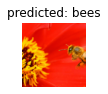

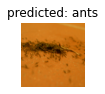

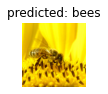

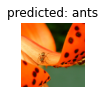

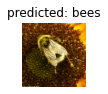

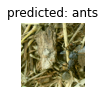

In [117]:
#예측한 결과를 보여주는 코드
visualize_model(model_ft)

In [120]:
#전연결이 되지 않은 부분(마지막부분)을 제외한 컨벌루션 레이어를 고정시키기 위한 코드
model_conv = torchvision.models.resnet18(pretrained=True)
for parm in model_conv.parameters():
    parm.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01,momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.01)

In [121]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)
# ACC: accuracy

Epoch 0/99
----------
train Loss: 2.2962 Acc: 0.6352
val Loss: 0.9084 Acc: 0.9020

Epoch 1/99
----------
train Loss: 2.3270 Acc: 0.7541
val Loss: 0.6220 Acc: 0.9281

Epoch 2/99
----------
train Loss: 3.3175 Acc: 0.7090
val Loss: 0.9379 Acc: 0.9150

Epoch 3/99
----------
train Loss: 1.4485 Acc: 0.7992
val Loss: 5.4391 Acc: 0.6863

Epoch 4/99
----------
train Loss: 4.8146 Acc: 0.6967
val Loss: 1.3438 Acc: 0.9020

Epoch 5/99
----------
train Loss: 2.0612 Acc: 0.8443
val Loss: 1.2649 Acc: 0.9542

Epoch 6/99
----------
train Loss: 2.9715 Acc: 0.8033
val Loss: 2.9934 Acc: 0.7908

Epoch 7/99
----------
train Loss: 4.2480 Acc: 0.7377
val Loss: 1.5200 Acc: 0.8889

Epoch 8/99
----------
train Loss: 2.7533 Acc: 0.7992
val Loss: 1.2160 Acc: 0.9346

Epoch 9/99
----------
train Loss: 1.2304 Acc: 0.8607
val Loss: 1.2742 Acc: 0.9281

Epoch 10/99
----------
train Loss: 1.3332 Acc: 0.8402
val Loss: 1.1686 Acc: 0.9542

Epoch 11/99
----------
train Loss: 1.0185 Acc: 0.8934
val Loss: 1.3013 Acc: 0.9412

Ep

train Loss: 2.0899 Acc: 0.8074
val Loss: 1.1824 Acc: 0.9412

Epoch 99/99
----------
train Loss: 1.6840 Acc: 0.8566
val Loss: 1.3216 Acc: 0.9412

Training complete in 3m 39s
Best val Acc: 0.960784


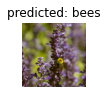

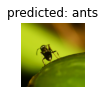

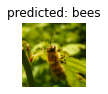

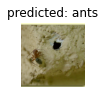

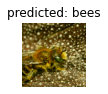

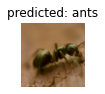

In [123]:
visualize_model(model_conv)

plt.ioff()   #ioff : 그림과 관련된 모든 함수를 실행
plt.show()